In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [2]:
data_dir = "data/PdM/"

df_mst = pd.read_csv(data_dir + "ics_asset_mst.csv", na_values='\\N')
df_sigdata = pd.read_csv(data_dir + "ics_asset_sigdata.csv", na_values='\\N')
df_status_hist = pd.read_csv(data_dir + "ics_asset_status_hist.csv", na_values='\\N')

df_sensor1 = pd.read_csv(data_dir + "55285839-9b78-48d8-9f4e-573190ace016_data.csv")

df_mst.columns = ['ASSET_ID', 'ASSET_NAME', 'SENSOR_NUMBER']
df_sigdata.columns = ['asset_id', 'created_at',	'temperature', 'voltage',
                      'rms_x', 'rms_y', 'rms_z', 'rms_xyz', 'vel_rms_x', 'vel_rms_y', 'vel_rms_z', 'vel_rms_xyz',
                      'skewness_x', 'skewness_y', 'skewness_z', 'vel_skewness_x', 'vel_skewness_y', 'vel_skewness_z',
                      'kurtosis_x', 'kurtosis_y', 'kurtosis_z', 'vel_kurtosis_x', 'vel_kurtosis_y', 'vel_kurtosis_z',
                      'crest_factor_x', 'crest_factor_y', 'crest_factor_z', 'vel_crest_factor_x', 'vel_crest_factor_y', 'vel_crest_factor_z',
                      'peak_x', 'peak_y', 'peak_z', 'vel_peak_x', 'vel_peak_y', 'vel_peak_z',
                      'peak2peak_x', 'peak2peak_y', 'peak2peak_z', 'vel_peak2peak_x', 'vel_peak2peak_y', 'vel_peak2peak_z']
df_status_hist.columns = ['asset_id', 'time', 'imbalance_health', 'misalignment_health', 'looseness_health', 'bearing_health', 'asset_health', 'CRT_DT']

In [3]:
# created_at을 datetime으로 변환
df_sensor1['created_at'] = pd.to_datetime(df_sensor1['created_at'], unit='s') + pd.Timedelta(hours=9)
# status_hist의 time을 datetime으로 변환
df_status_hist['time'] = pd.to_datetime(df_status_hist['time'])

In [4]:
# 1월 10일부터 7월 31일까지의 데이터만 사용
df_sensor1 = df_sensor1[(df_sensor1['created_at'] >= '2024-01-10') & (df_sensor1['created_at'] <= '2024-07-31')].reset_index(drop=True)
df_status_hist = df_status_hist[(df_status_hist['time'] >= '2024-01-10') & (df_status_hist['time'] <= '2024-07-31')].reset_index(drop=True).drop('CRT_DT', axis=1)

In [5]:
df_input = df_sensor1.drop(columns=['asset_id', 'created_at', 'created_at_datetime', 'time', 'imbalance_health', 'misalignment_health', 'looseness_health', 'bearing_health', 'asset_health'])

In [8]:
# 데이터 전처리
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_input)

# AutoEncoder 모델 정의
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)

# Decoder
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# 모델 생성
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
history = autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=False, validation_split=0.2)

# Reconstruction Loss 계산
X_pred = autoencoder.predict(X_scaled)
rmse = np.sqrt(np.mean(np.power(X_scaled - X_pred, 2), axis=1))

# 이상 탐지 임계값 설정
threshold = np.percentile(rmse, 90)
anomalies = rmse > threshold

Epoch 1/50
56/56 [==============================] - 1s 5ms/step - loss: 1.1765 - val_loss: 0.8971
Epoch 2/50
56/56 [==============================] - 0s 1ms/step - loss: 0.8346 - val_loss: 0.6653
Epoch 3/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7559 - val_loss: 0.6538
Epoch 4/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7442 - val_loss: 0.6457
Epoch 5/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7302 - val_loss: 0.6359
Epoch 6/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7155 - val_loss: 0.6265
Epoch 7/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7082 - val_loss: 0.6211
Epoch 8/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7031 - val_loss: 0.6169
Epoch 9/50
56/56 [==============================] - 0s 1ms/step - loss: 0.7002 - val_loss: 0.6154
Epoch 10/50
56/56 [==============================] - 0s 1ms/step - loss: 0.6970 - val_loss: 0.6148
Epoch 11/50
56/56 [

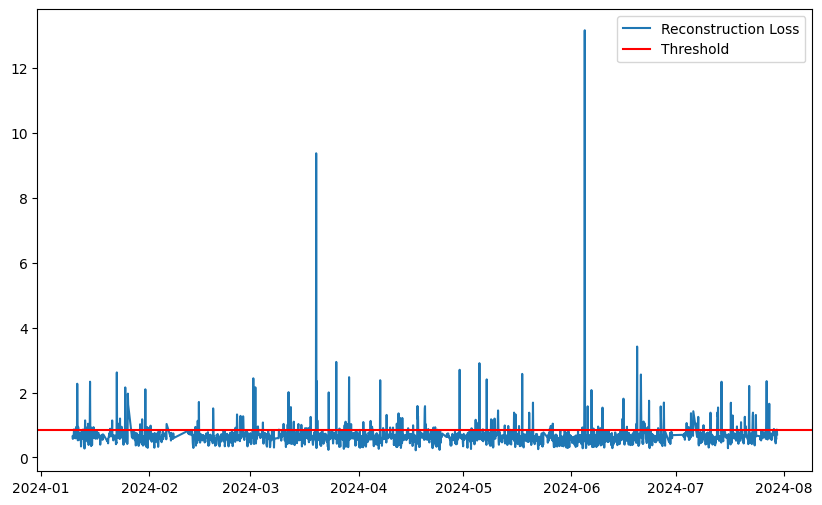

In [15]:
# 결과 시각화
df_sensor1['Anomaly'] = anomalies
plt.figure(figsize=(10,6))
plt.plot(df_sensor1['created_at'], rmse, label='Reconstruction Loss')
plt.axhline(y=threshold, color='r', linestyle='-', label='Threshold')
plt.legend()
plt.show()

In [16]:
(df_sensor1['Anomaly'] == False).sum()

2004

In [17]:
(df_sensor1['Anomaly'] == True).sum()

223

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = df_sensor1['imbalance_health'].apply(lambda x: x != 1)
y_pred = df_sensor1['Anomaly']

# 정확도, 정밀도, 재현율, F1 스코어 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.84
Precision: 0.13
Recall: 0.15
F1 Score: 0.14


In [19]:
(y_pred == True).sum()

223

In [20]:
(y_true == True).sum()

191

In [ ]:
df_sensor1